In [1]:
import matplotlib.pyplot as plt
from gerrychain import (GeographicPartition, Partition, Graph, MarkovChain,
                        proposals, updaters, constraints, accept, Election)
from gerrychain.proposals import recom, propose_random_flip
from gerrychain.tree import recursive_tree_part
from gerrychain.metrics import mean_median, efficiency_gap, polsby_popper, partisan_gini
from functools import (partial, reduce)
import pandas
import geopandas as gp
import numpy as np
import networkx as nx
import pickle
import seaborn as sns
import pprint
import operator
import scipy
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale, normalize
import random
from nltk.util import bigrams
from nltk.probability import FreqDist
from gingleator import Gingleator
from numpy.random import randn
from scipy.stats import norm, probplot

In [2]:
## Set up AR
graph_AR = pickle.load(open("graph_AR.p", "rb"))
df_AR = pickle.load(open("df_AR.p", "rb"))

AR_updaters = {"population": updaters.Tally("TOTPOP", alias="population"),
               "bvap": updaters.Tally("BVAP", alias="bvap"),
               "vap": updaters.Tally("VAP", alias="vap"),
               "bvap_prec": lambda part: {k: part["bvap"][k] / part["vap"][k]
                                          for k in part["bvap"]}}

AR_enacted_senate = GeographicPartition(graph_AR, assignment="SSD", updaters=AR_updaters)

In [3]:
total_population_AR = sum(df_AR.TOTPOP.values)
ideal_population_AR = total_population_AR / 35

In [4]:
senate_seed = recursive_tree_part(graph_AR, range(35), pop_col="TOTPOP",
                                pop_target=ideal_population_AR,
                                epsilon=0.01, node_repeats=1)
AR_seed_senate = GeographicPartition(graph_AR, assignment=senate_seed,updaters=AR_updaters)

In [5]:
Gingleator.num_opportunity_dists(AR_seed_senate, "bvap_prec", 0.4)

3

In [6]:
Gingleator.reward_partial_dist(AR_seed_senate, "bvap_prec", 0.4)

3.371373070863733

In [7]:
Gingleator.reward_next_highest_close(AR_seed_senate, "bvap_prec", 0.4)

3.71373070863733

In [11]:
AR_gingles_partial = Gingleator(AR_seed_senate, pop_col="TOTPOP", minority_prec_col="bvap_prec",
                                epsilon=0.1, score_funct=Gingleator.reward_partial_dist)

In [12]:
AR_gingles_num = Gingleator(AR_seed_senate, pop_col="TOTPOP", minority_prec_col="bvap_prec",
                            epsilon=0.1)

In [8]:
AR_gingles_cont = Gingleator(AR_seed_senate, pop_col="TOTPOP", minority_prec_col="bvap_prec",
                            epsilon=0.1, score_funct=Gingleator.reward_next_highest_close)

In [13]:
_, AR_observations_partial = AR_gingles_partial.short_burst_run(num_bursts=100, num_steps=10)

In [14]:
_, AR_observations_num = AR_gingles_num.short_burst_run(num_bursts=100, num_steps=10)

In [10]:
_, AR_observations_cont = AR_gingles_cont.short_burst_run(num_bursts=100, num_steps=10)

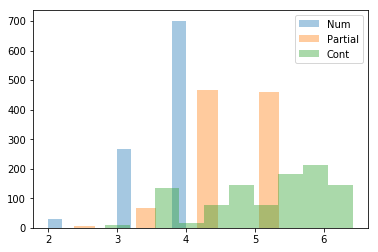

In [17]:
plt.figure()
sns.distplot(AR_observations_num.flatten(), bins=10, kde=False, label="Num")
sns.distplot(AR_observations_partial.flatten(), bins=10, kde=False, label="Partial")
sns.distplot(AR_observations_cont.flatten(), bins=10, kde=False, label="Cont")
plt.legend()
plt.show()

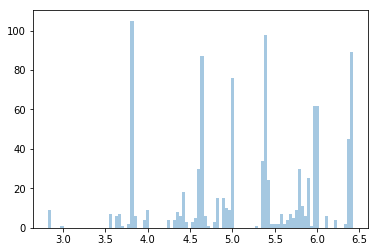

In [21]:
sns.distplot(AR_observations_cont.flatten(), bins=100, kde=False, label="Cont")


In [24]:
AR_observations_cont

array([[3.71373071, 3.82533371, 3.82533371, 3.82533371, 3.82533371,
        3.82533371, 3.82533371, 3.82533371, 3.82533371, 3.82533371],
       [3.82533371, 3.82533371, 3.82533371, 3.82533371, 3.82533371,
        3.82533371, 3.82533371, 3.82533371, 3.82533371, 3.82533371],
       [3.82533371, 3.82533371, 3.82533371, 3.82533371, 3.82533371,
        2.82533371, 2.82533371, 2.82533371, 2.82533371, 2.82533371],
       [3.82533371, 3.82533371, 3.82533371, 3.82533371, 3.82533371,
        3.82533371, 3.82533371, 3.82533371, 3.82533371, 3.82533371],
       [3.82533371, 3.82533371, 3.82533371, 3.57625611, 3.57625611,
        3.57625611, 3.57625611, 3.57625611, 3.57625611, 3.57625611],
       [3.82533371, 3.82533371, 3.82533371, 3.82533371, 3.82533371,
        3.82533371, 3.82533371, 3.82533371, 3.82533371, 3.82533371],
       [3.82533371, 3.82533371, 3.82533371, 3.82533371, 3.82533371,
        3.82533371, 3.82533371, 3.82533371, 3.82533371, 3.82533371],
       [3.82533371, 3.82533371, 3.8253337

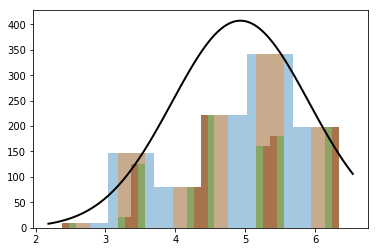

In [42]:
mu, std = norm.fit(AR_observations.flatten())
sns.distplot(AR_observations.flatten(), bins=6, kde=False)
sns.distplot(AR_observations.flatten(), bins=10, kde=False)
sns.distplot(AR_observations.flatten(), bins=20, kde=False)
sns.distplot(AR_observations.flatten(), bins=40, kde=False)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p*1000, 'k', linewidth=2)

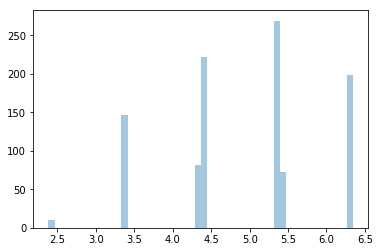

In [45]:
sns.distplot(AR_observations.flatten(), bins=50, kde=False)